# Allstate claims severity - Kaggle challenge

## Intro
When you’ve been devastated by a serious car accident, your focus is on the things that matter the most: family, friends, and other loved ones. Pushing paper with your insurance agent is the last place you want your time or mental energy spent. This is why Allstate, a personal insurer in the United States, is continually seeking fresh ideas to improve their claims service for the over 16 million households they protect. Allstate is currently developing automated methods of predicting the cost, and hence severity, of claims. In this recruitment challenge, Kagglers are invited to show off their creativity and flex their technical chops by creating an algorithm which accurately predicts claims severity. Aspiring competitors will demonstrate insight into better ways to predict claims severity for the chance to be part of Allstate’s efforts to ensure a worry-free customer experience...

## Content:
1. Housekeeping and Imports
2. Data Loading
3. Data Exploration
4. Data Cleaning
5. Feature Engineering
6. Data Transformation and Preparation
7. Model Exploration and Performance Analysis
8. Final Model Building
9. Prediction on test set


## 1. Housekeeping and Imports

For importing libraries necessary for the project, and for basic preprocessing functions (ex: typset conversion for NLP projects). 

In [1]:
install.packages('data.table')
install.packages('Matrix')
install.packages('Metrics')
install.packages("xgboost")
install.packages("corrplot")
install.packages("magrittr")

Installing package into ‘/home/adri/R/x86_64-pc-linux-gnu-library/3.4’
(as ‘lib’ is unspecified)
Installing package into ‘/home/adri/R/x86_64-pc-linux-gnu-library/3.4’
(as ‘lib’ is unspecified)
Installing package into ‘/home/adri/R/x86_64-pc-linux-gnu-library/3.4’
(as ‘lib’ is unspecified)
Installing package into ‘/home/adri/R/x86_64-pc-linux-gnu-library/3.4’
(as ‘lib’ is unspecified)
Installing package into ‘/home/adri/R/x86_64-pc-linux-gnu-library/3.4’
(as ‘lib’ is unspecified)
Installing package into ‘/home/adri/R/x86_64-pc-linux-gnu-library/3.4’
(as ‘lib’ is unspecified)


In [2]:
library(data.table)
library(Matrix)
library(xgboost)
library(Metrics)
library(magrittr)

## 2. Data Loading

For loading data files into appropriate variables.

In [21]:
TRAIN_FILE = "../train.csv"
TEST_FILE = "../test.csv"
SUBMISSION_FILE = "../sample_submission.csv"

# Reads a file in table format and creates a data frame from it, 
# with cases corresponding to lines and variables to fields in the file.

train = fread(TRAIN_FILE, showProgress = TRUE)
train$id = NULL
test = fread(TEST_FILE, showProgress = TRUE)

## 3. Data Exploration

Section for **exploratory analysis** on the available data. 

The exploration techniques vary for numerical, categorical, or time-series variables. Currently, 

Here we typically:

- look at example records in the dataset
- investigate the datatypes of variables in the dataset
- calculate and investigate descriptive statistics (ex: central tendencies, variability etc.)
- investigate distribution of feature vectors (ex: to check for skewness and outliers)
- investigate distribution of prediction vector
- check out the relationship (ex: correlation) between different features
- check out the relationship between feature vectors and prediction vector

Common steps to check the health of the data:

- Check for missing data
- Check the skewness of the data, outlier detection
- etc...

### Example Records

In [4]:
head(train, n = 10)

cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,⋯,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
A,B,A,B,A,A,A,A,B,A,⋯,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
A,B,A,A,A,A,A,A,B,B,⋯,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
A,B,A,A,B,A,A,A,B,B,⋯,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
B,B,A,B,A,A,A,A,B,A,⋯,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
A,B,A,B,A,A,A,A,B,B,⋯,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85
A,B,A,A,A,A,A,A,B,A,⋯,0.364464,0.401162,0.26847,0.46226,0.50556,0.366788,0.359249,0.345247,0.726792,5142.87
A,A,A,A,B,A,A,A,A,A,⋯,0.381515,0.363768,0.24564,0.40455,0.47225,0.334828,0.352251,0.342239,0.382931,1132.22
A,B,A,B,A,A,A,A,B,A,⋯,0.867021,0.583389,0.90267,0.84847,0.80218,0.644013,0.785706,0.859764,0.242416,3585.75
A,B,B,B,B,A,A,A,B,B,⋯,0.628534,0.384099,0.61229,0.38249,0.51111,0.682315,0.669033,0.756454,0.361191,10280.20
A,B,A,A,B,B,A,A,B,A,⋯,0.713343,0.469223,0.30260,0.67135,0.83510,0.863052,0.879347,0.822493,0.294523,6184.59


In [5]:
head(test, n = 10)

id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,⋯,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
4,A,B,A,A,A,A,A,A,B,⋯,0.281143,0.466591,0.317681,0.61229,0.34365,0.38016,0.377724,0.369858,0.704052,0.392562
6,A,B,A,B,A,A,A,A,B,⋯,0.836443,0.482425,0.443760,0.71330,0.51890,0.60401,0.689039,0.675759,0.453468,0.208045
9,A,B,A,B,B,A,B,A,B,⋯,0.718531,0.212308,0.325779,0.29758,0.34365,0.30529,0.245410,0.241676,0.258586,0.297232
12,A,A,A,A,B,A,A,A,A,⋯,0.397069,0.369930,0.342355,0.40028,0.33237,0.31480,0.348867,0.341872,0.592264,0.555955
15,B,A,A,A,A,B,A,A,A,⋯,0.302678,0.398862,0.391833,0.23688,0.43731,0.50556,0.359572,0.352251,0.301535,0.825823
17,A,A,A,A,B,A,A,A,A,⋯,0.643315,0.407351,0.390540,0.46477,0.46853,0.50556,0.607500,0.594646,0.250991,0.283976
21,B,A,A,A,B,B,A,A,A,⋯,0.281143,0.960845,0.740081,0.75964,0.98330,0.82249,0.863052,0.879347,0.888944,0.787807
28,B,B,A,A,A,A,A,A,B,⋯,0.651246,0.451115,0.316313,0.27320,0.52100,0.50556,0.415029,0.481306,0.199940,0.450597
32,A,B,A,A,A,A,A,A,B,⋯,0.534484,0.343492,0.358758,0.81900,0.32128,0.36458,0.453334,0.443374,0.695650,0.295075
43,A,B,A,A,A,A,A,A,B,⋯,0.281143,0.394921,0.287416,0.92347,0.48320,0.24766,0.359572,0.352251,0.519989,0.602666


In [6]:
dim(train) # dimensions of train data

[1] 188318    131

In [7]:
dim(test) # dimensions of test data

[1] 125546    131

### Data-types, completeness Information

In [8]:
sapply(train, class) # data types of each feature

cat1        cat2        cat3        cat4        cat5        cat6 
"character" "character" "character" "character" "character" "character" 
       cat7        cat8        cat9       cat10       cat11       cat12 
"character" "character" "character" "character" "character" "character" 
      cat13       cat14       cat15       cat16       cat17       cat18 
"character" "character" "character" "character" "character" "character" 
      cat19       cat20       cat21       cat22       cat23       cat24 
"character" "character" "character" "character" "character" "character" 
      cat25       cat26       cat27       cat28       cat29       cat30 
"character" "character" "character" "character" "character" "character" 
      cat31       cat32       cat33       cat34       cat35       cat36 
"character" "character" "character" "character" "character" "character" 
      cat37       cat38       cat39       cat40       cat41       cat42 
"character" "character" "character" "character" "character" "character" 
      cat43       cat44       cat45       cat46       cat47       cat48 
"character" "character" "character" "character" "character" "character" 
      cat49       cat50       cat51       cat52       cat53       cat54 
"character" "character" "character" "character" "character" "character" 
      cat55       cat56       cat57       cat58       cat59       cat60 
"character" "character" "character" "character" "character" "character" 
      cat61       cat62       cat63       cat64       cat65       cat66 
"character" "character" "character" "character" "character" "character" 
      cat67       cat68       cat69       cat70       cat71       cat72 
"character" "character" "character" "character" "character" "character" 
      cat73       cat74       cat75       cat76       cat77       cat78 
"character" "character" "character" "character" "character" "character" 
      cat79       cat80       cat81       cat82       cat83       cat84 
"character" "character" "character" "character" "character" "character" 
      cat85       cat86       cat87       cat88       cat89       cat90 
"character" "character" "character" "character" "character" "character" 
      cat91       cat92       cat93       cat94       cat95       cat96 
"character" "character" "character" "character" "character" "character" 
      cat97       cat98       cat99      cat100      cat101      cat102 
"character" "character" "character" "character" "character" "character" 
     cat103      cat104      cat105      cat106      cat107      cat108 
"character" "character" "character" "character" "character" "character" 
     cat109      cat110      cat111      cat112      cat113      cat114 
"character" "character" "character" "character" "character" "character" 
     cat115      cat116       cont1       cont2       cont3       cont4 
"character" "character"   "numeric"   "numeric"   "numeric"   "numeric" 
      cont5       cont6       cont7       cont8       cont9      cont10 
  "numeric"   "numeric"   "numeric"   "numeric"   "numeric"   "numeric" 
     cont11      cont12      cont13      cont14        loss 
  "numeric"   "numeric"   "numeric"   "numeric"   "numeric"

In [9]:
install.packages("tidyverse")
library(tidyverse)

Installing package into ‘/home/adri/R/x86_64-pc-linux-gnu-library/3.4’
(as ‘lib’ is unspecified)
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.4
✔ tibble  1.4.2     ✔ dplyr   0.7.4
✔ tidyr   0.8.0     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ tidyr::expand()    masks Matrix::expand()
✖ tidyr::extract()   masks magrittr::extract()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::set_names() masks magrittr::set_names()
✖ dplyr::slice()     masks xgboost::slice()
✖ purrr::transpose() masks data.table::transpose()


In [22]:
train <- train %>% mutate_if(is.character,as.factor)

In [23]:
test <- test %>% mutate_if(is.character,as.factor)

### Check for missing values

In [19]:
if (sum(is.nan(as.matrix(train)))==0){
    print('No Values Missing')
}

[1] "No Values Missing"


### Descriptive Statistics

In [13]:
summary(train)

 cat1       cat2       cat3       cat4       cat5       cat6       cat7      
 A:141550   A:106721   A:177993   A:128395   A:123737   A:131693   A:183744  
 B: 46768   B: 81597   B: 10325   B: 59923   B: 64581   B: 56625   B:  4574  
                                                                             
                                                                             
                                                                             
                                                                             
                                                                             
 cat8       cat9       cat10      cat11      cat12      cat13      cat14     
 A:177274   A:113122   A:160213   A:168186   A:159825   A:168851   A:186041  
 B: 11044   B: 75196   B: 28105   B: 20132   B: 28493   B: 19467   B:  2277  
                                                                             
                                                                

In [14]:
# This calculates the standard deviation for each numeric attribute in the dataset.
sapply(train[,118:131], sd)

cont2        cont3        cont4        cont5        cont6        cont7 
   0.2072017    0.2021046    0.2112922    0.2090268    0.2052726    0.1784502 
       cont8        cont9       cont10       cont11       cont12       cont13 
   0.1993705    0.1816602    0.1858767    0.2097365    0.2094266    0.2127772 
      cont14         loss 
   0.2224875 2904.0861864

### Visualizaton: Distribution of features

*Section has great potential for expansion.* 

Visualization techniques differ depending on the type of the feature vector (i.e. numerical: continuous or discrete, categorical: ordinal etc). Techniques will also depend on the type of data being dealt with, and the insight that we want to extract from it. 

Common visualization techniques include:
- Bar Plots: Visualize the frequency distribution of categorical features.
- Histograms: Visualize the frequency distribution of numerical features.
- Box Plots: Visualize a numerical feature, while providing more information like the median, lower/upper quantiles etc..
- Scatter Plots: Visualize the relationship (usually the correlation) between two features. Can include a goodness of fit line, to serve as a regression plot.

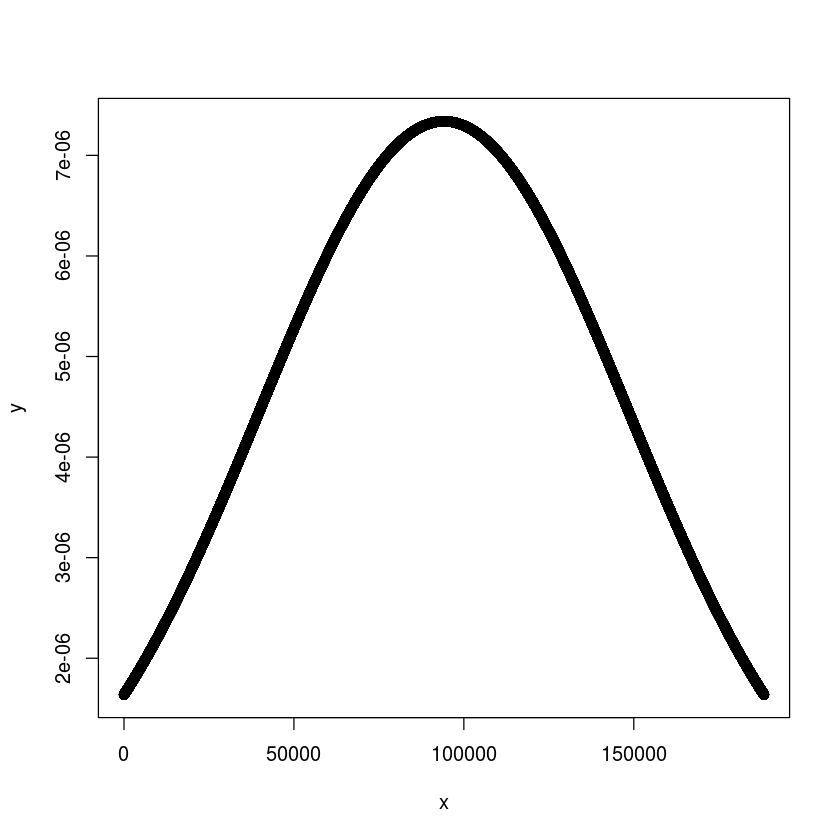

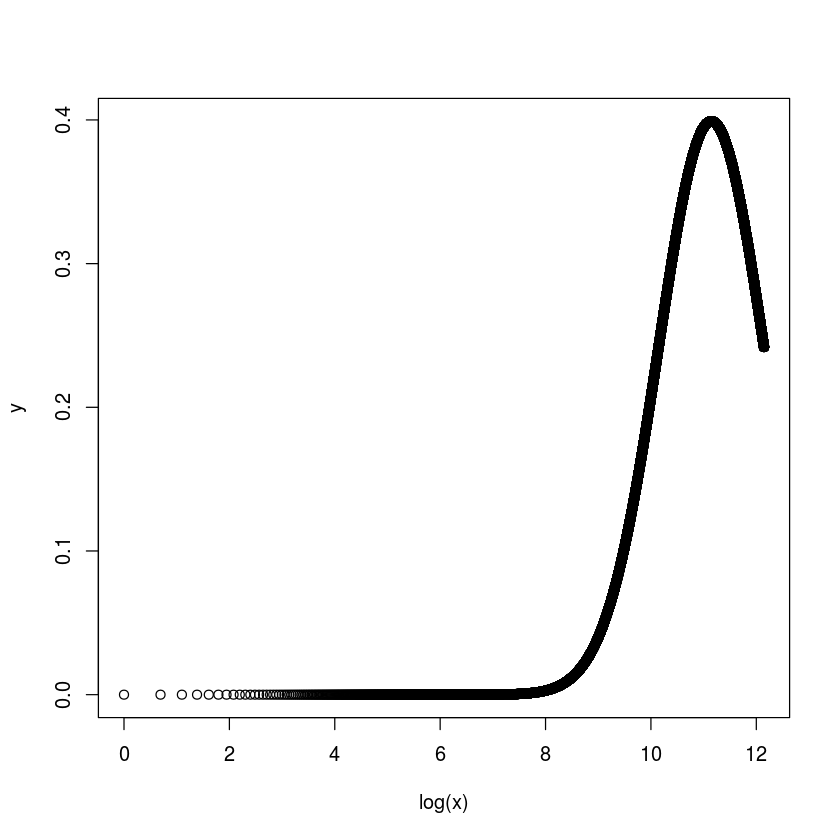

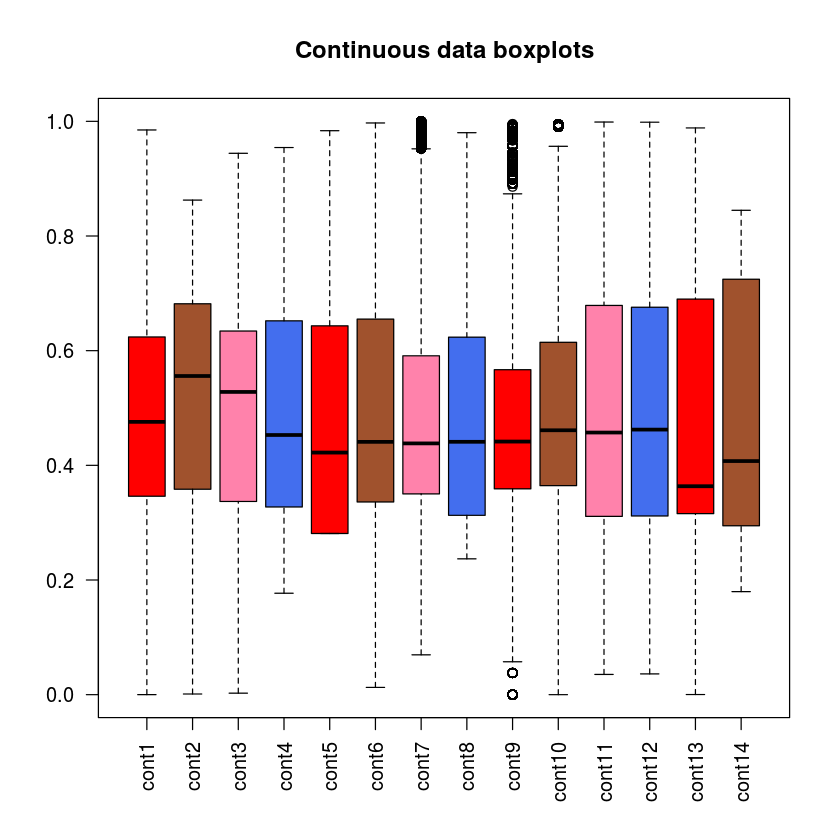

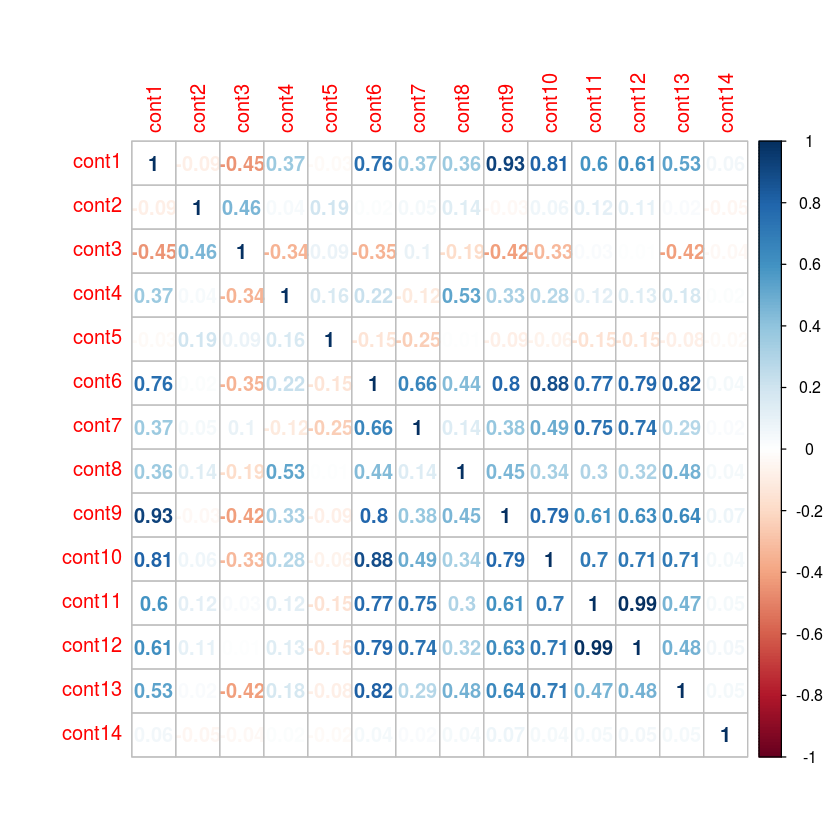

In [24]:
#extract continuous variables
dfCont = data.frame(row.names=1:nrow(train))
for(i in 1:length(train)){
    if (sapply(train[i], is.numeric) == TRUE){
        #contCol = list.append(contCol,head(df[i],n=0))
        dfCont = cbind(dfCont,train[i])
        }
    }

##check if the loss column has normal distribution - yes it has
x = dfCont['loss']
x = seq(x[-1,])
y = dnorm(x, mean = mean(x), sd = sd(x))
plot(x,y)

#apply lognormal to reduce the scale and control negative values
y = dnorm(log(x), mean = mean(log(x)), sd = sd(log(x)))
plot(log(x),y)

#get the categorical values
dfAlph = data.frame(row.names=1:nrow(train))
for(i in 1:length(train)){
    if (sapply(train[i], is.numeric) == FALSE){
        #contCol = list.append(contCol,head(df[i],n=0))
        dfAlph = cbind(dfAlph,train[i])
        }
    }

#draw boxplots for them
#delete loss column or else huge outliers there
dfCont[length(dfCont)] = NULL
boxplot(dfCont, las=2, main="Continuous data boxplots", col=c("red","sienna","palevioletred1","royalblue2","red","sienna","palevioletred1","royalblue2","red","sienna","palevioletred1","royalblue2"))

#correlation between continuous features including loss
scaled.dfCont = scale(dfCont)     #normalize
#zVar <- (corrM - mean(corrM)) / sd(corrM)     #z-transformation
corrM = cor(dfCont)
library(corrplot)
corrplot(corrM, method="number")


### Investigating correlations between features

### Visualizing prediction vector

### Investigating missing values

### Outlier Detection

The presence of outliers can often skew results which take into consideration these data points. 

One approach to detect outliers is to use Tukey's Method for identfying them: An outlier step is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal.

## 4. Data Cleaning

### Imputing missing values

### Cleaning outliers or error values

## 5. Feature Engineering

Section to extract more features from those currently available.

## 6. Data Transformation and Preparation

### Transforming Skewed Continous Features 

It is common practice to apply a logarthmic transformation to highly skewed continuous feature distributions.

### Normalizing Numerical Features 

Another common practice is to perform some type of scaling on numerical features. Applying scaling doesn't change the shape of each feature's distribution; but ensures that each feature is treated equally when applying supervised learners.

### One Hot Encoding Categorical Features

It is encouraged to create a pipeline function for data preprocessing, rather than separate script blocks.

### Shuffle and Split Data

## 7. Model Exploration

### Naive Predictor Performance

To set a baseline for the performance of the predictor. 

Common techniques:
- For categorical prediction vector, choose the most common class
- For numerical prediction vector, choose a measure of central tendency

Then calculate the evalation metric (accuracy, f-score etc)

### Choosing scoring metrics

### Creating a Training and Prediction Pipeling

### Model Evaluation

## 8. Final Model Building

Using grid search (GridSearchCV) with different parameter/value combinations, we can tune our model for even better results.

Next steps can include feature importance extraction, predictions on the test set.. etc

## 9. Predictions on Test Set